## For download the dataset, please visit:

https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

In [1]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)
print(tf.__version__)

2.9.1


## Load Image

In [22]:
height, width = 224, 224
batch_size=64

data_dir = 'brain_tumor_dataset'

def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              #seed=123,
              #color_mode = 'grayscale',
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
            classes={'no': 0., 'yes': 1.}
            )
    return train_ds, val_ds

train_ds, val_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


## Image demonstration

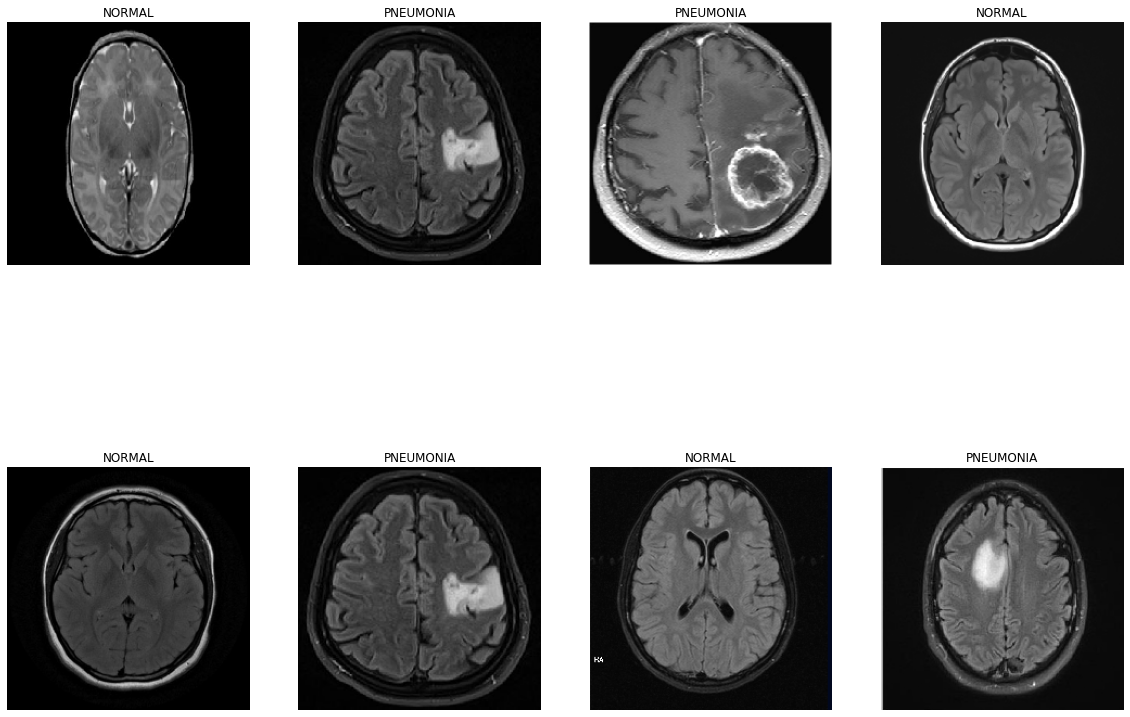

In [23]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title('PNEUMONIA' if img_label[i] == 1.0 else 'NORMAL')
        plt.axis("off")
        
    plt.show()
image_plot(train_ds,8)

## VGG19

In [3]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
#model_vgg19.add(tf.keras.layers.GlobalMaxPooling2D())
model_vgg19.add(tf.keras.layers.Flatten())
#model_vgg19.add(tf.keras.layers.Dropout(0.25))
#model_vgg19.add(tf.keras.layers.Dense(64, activation='relu'))
#model_vgg19.add(tf.keras.layers.Dense(32, activation='relu'))
#model_vgg19.add(tf.keras.layers.Dropout(0.1))

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [4]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 9.1089 - acc: 0.5665 
Epoch 1: acc improved from -inf to 0.56650, saving model to model\vgg19_best.h5
4/4 [==============================] - 22s 5s/step - loss: 9.1089 - acc: 0.5665 - val_loss: 12.8675 - val_acc: 0.6200
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 11.0078 - acc: 0.6108
Epoch 2: acc improved from 0.56650 to 0.61084, saving model to model\vgg19_best.h5
4/4 [==============================] - 20s 5s/step - loss: 11.0078 - acc: 0.6108 - val_loss: 2.6156 - val_acc: 0.8000
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 5.4941 - acc: 0.5074
Epoch 3: acc did not improve from 0.61084
4/4 [==============================] - 20s 6s/step - loss: 5.4941 - acc: 0.5074 - val_loss: 3.5751 - val_acc: 0.6800
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 2.3230 - acc: 0.7783
Epoch 4: acc improved from 0.61084 to 0.77833, saving model to model\vgg19_best.h5
4/4 [====

## Accuracy Analysis

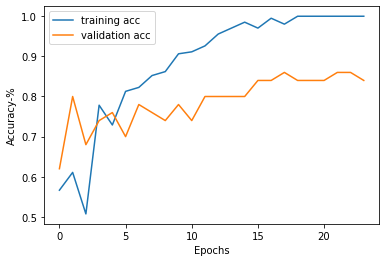

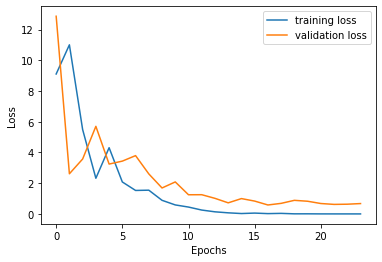

In [6]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [7]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 4s 4s/step - loss: 0.8864 - acc: 0.8400


,Train,Val
Loss,0.010224,0.886402
Acc,1.000000,0.840000


In [8]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(val_ds.classes)/batch_size)):
    xtest.append(val_ds[i][0]) 
    ytest= np.concatenate((ytest,val_ds[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg19.predict(xtest)
ypred = np.array([1 if x > 0.5 else 0 for x in ypred_prob])

print(confusion_matrix(ytest,ypred))
print(classification_report(ytest,ypred))

2/2 [==============================] - 4s 1s/step
[[12  7]
 [ 1 30]]
              precision    recall  f1-score   support

         0.0       0.92      0.63      0.75        19
         1.0       0.81      0.97      0.88        31

    accuracy                           0.84        50
   macro avg       0.87      0.80      0.82        50
weighted avg       0.85      0.84      0.83        50



## Wrong classification analysis 

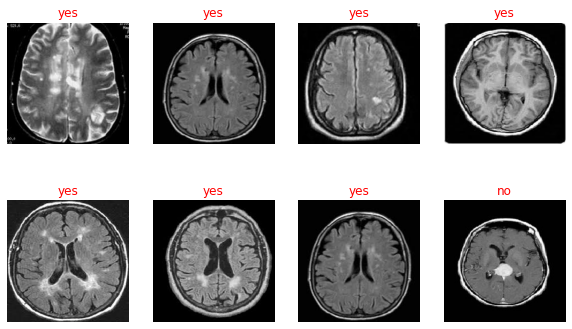

In [17]:
def plot_wrong_classes(ypred,ytest,image_numbers):
    
    wrong_pred = np.where(ypred!=ytest)[0]
    plt.figure(figsize=(10, 6))
    
    for i,n in enumerate(wrong_pred):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(xtest[n])
        plt.title('yes' if ypred[n] == 1.0 else 'no',color='r')
        plt.axis("off")
        
plot_wrong_classes(ypred,ytest,8)

## Image Augmentation

In [30]:
def augmentataion_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds
aug_train_ds = augmentataion_generator(height,width)

Found 253 images belonging to 2 classes.


## Plot image after image augmentation

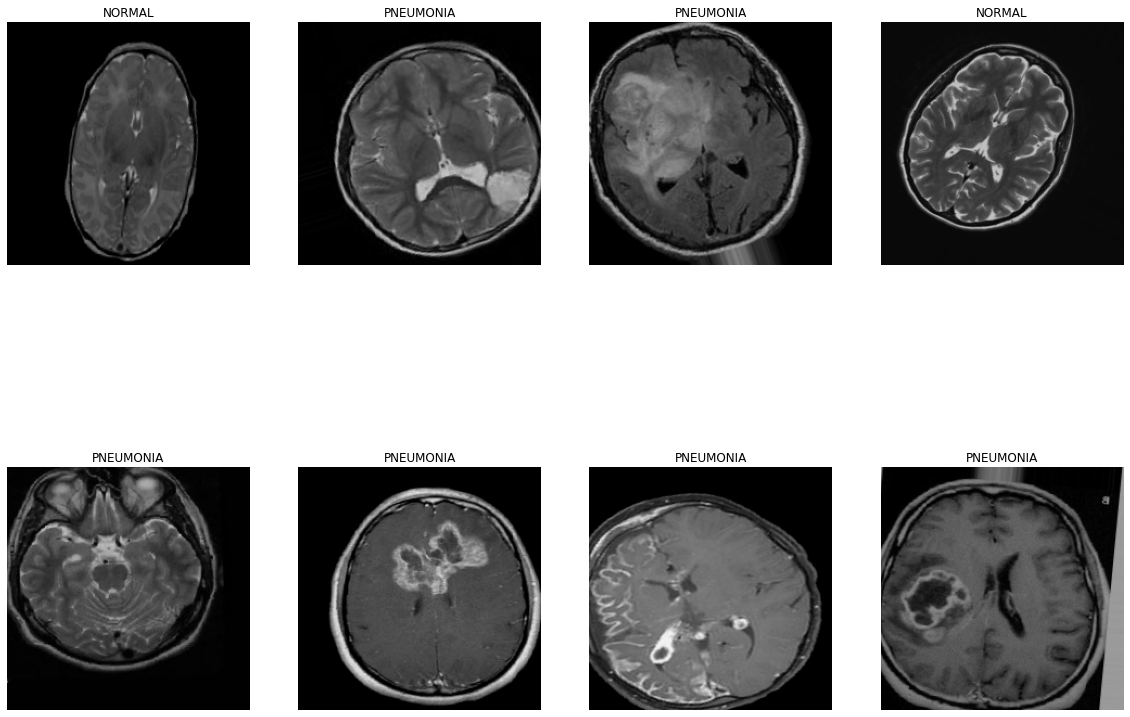

In [28]:
image_plot(aug_train_ds,8)

In [31]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)

callbacks_list = [checkpoint,reduce_lr]

history = model_vgg19.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 0.5980 - acc: 0.8538
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 25s 6s/step - loss: 0.5980 - acc: 0.8538 - val_loss: 0.7743 - val_acc: 0.8400 - lr: 0.0100
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.6371 - acc: 0.8300
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 24s 6s/step - loss: 0.6371 - acc: 0.8300 - val_loss: 0.5429 - val_acc: 0.9200 - lr: 0.0100
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.5041 - acc: 0.8379
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 24s 6s/step - loss: 0.5041 - acc: 0.8379 - val_loss: 0.3891 - val_acc: 0.9000 - lr: 0.0100
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.5026 - acc: 0.8696
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 24s 6s/step - loss: 0.5026 - acc: 0.8696 - val_loss: 0.

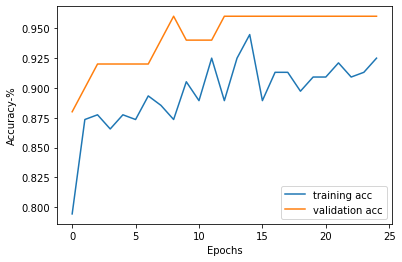

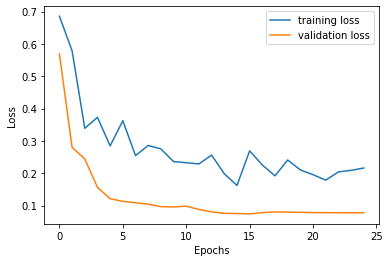

In [82]:
plot_learning_curve(history)

In [32]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 4s 4s/step - loss: 0.1514 - acc: 0.9200


,Train,Val
Loss,0.007455,0.151444
Acc,1.000000,0.920000


In [33]:
ypred_val = model_vgg19.predict(val_ds[0][0])
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])
y_val = val_ds[0][-1]

print(confusion_matrix(y_val, ypred_val))
print('\n',classification_report(ypred_val,y_val))

2/2 [==============================] - 4s 1s/step
[[16  3]
 [ 1 30]]

               precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.97      0.91      0.94        33

    accuracy                           0.92        50
   macro avg       0.90      0.93      0.91        50
weighted avg       0.93      0.92      0.92        50



## Inception v3

In [76]:
# inception v3
height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
#model_inceptionv3.add(tf.keras.layers.Dropout(0.2))
#model_inceptionv3.add(tf.keras.layers.Dense(8, activation='relu'))
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [77]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 8.5657 - acc: 0.5616
Epoch 1: acc improved from -inf to 0.56158, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 14s 3s/step - loss: 8.5657 - acc: 0.5616 - val_loss: 7.0674 - val_acc: 0.3800
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 4.0318 - acc: 0.5911
Epoch 2: acc improved from 0.56158 to 0.59113, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 9s 2s/step - loss: 4.0318 - acc: 0.5911 - val_loss: 2.6034 - val_acc: 0.7200
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 2.2944 - acc: 0.7635
Epoch 3: acc improved from 0.59113 to 0.76355, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 9s 2s/step - loss: 2.2944 - acc: 0.7635 - val_loss: 0.7953 - val_acc: 0.9200
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.6442 - acc: 0.8867
Epoch 4: acc improved from 0.76355 to 0

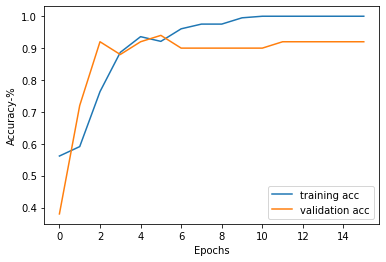

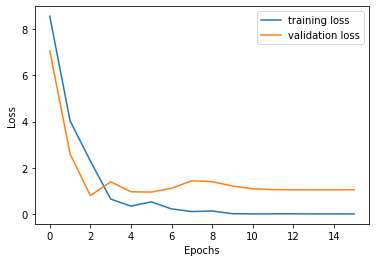

In [78]:
plot_learning_curve(history)

In [79]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 2s 2s/step - loss: 1.0854 - acc: 0.9000


,Train,Val
Loss,0.001777,1.085411
Acc,1.000000,0.900000


In [67]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(val_ds.classes)/batch_size)):
    xtest.append(val_ds[i][0]) 
    ytest= np.concatenate((ytest,val_ds[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_inceptionv3.predict(xtest)
ypred = np.array([1 if x > 0.5 else 0 for x in ypred_prob])

print(confusion_matrix(ytest,ypred))
print(classification_report(ytest,ypred))

2/2 [==============================] - 2s 637ms/step
[[16  3]
 [ 0 31]]
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91        19
         1.0       0.91      1.00      0.95        31

    accuracy                           0.94        50
   macro avg       0.96      0.92      0.93        50
weighted avg       0.95      0.94      0.94        50



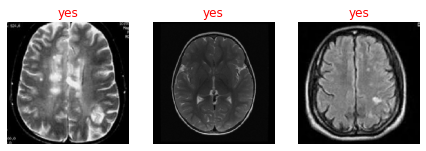

In [80]:
plot_wrong_classes(ypred,ytest,3)

In [81]:
aug_train_ds = augmentataion_generator(height,width)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)

early = tf.keras.callbacks.EarlyStopping(monitor="val_acc",restore_best_weights=True, patience=10)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=30, 
        verbose=True,
        callbacks=callbacks_list)

Found 253 images belonging to 2 classes.
Epoch 1/30
4/4 [==============================] - ETA: 0s - loss: 1.6514 - acc: 0.8498
Epoch 1: acc improved from -inf to 0.84980, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 13s 3s/step - loss: 1.6514 - acc: 0.8498 - val_loss: 3.5087 - val_acc: 0.6600
Epoch 2/30
4/4 [==============================] - ETA: 0s - loss: 1.5000 - acc: 0.8063
Epoch 2: acc did not improve from 0.84980
4/4 [==============================] - 13s 3s/step - loss: 1.5000 - acc: 0.8063 - val_loss: 1.0253 - val_acc: 0.9000
Epoch 3/30
4/4 [==============================] - ETA: 0s - loss: 1.1876 - acc: 0.8538
Epoch 3: acc improved from 0.84980 to 0.85375, saving model to model\inceptionv3_best.h5
4/4 [==============================] - 12s 3s/step - loss: 1.1876 - acc: 0.8538 - val_loss: 0.7856 - val_acc: 0.9200
Epoch 4/30
4/4 [==============================] - ETA: 0s - loss: 0.6769 - acc: 0.8814
Epoch 4: acc improved from 0.85375 to 0.881

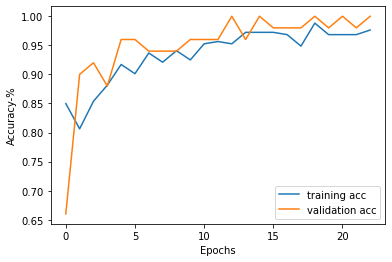

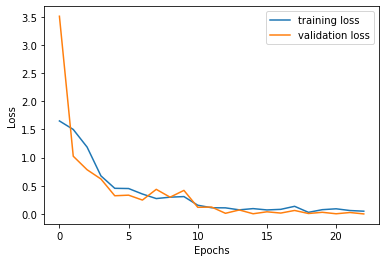

In [82]:
plot_learning_curve(history)

In [83]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 2s 2s/step - loss: 0.0127 - acc: 1.0000


,Train,Val
Loss,0.000213,0.012721
Acc,1.000000,1.000000


In [84]:
ypred = model_inceptionv3.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

2/2 [==============================] - 3s 658ms/step
Confusion_Matrix:
 [[19  0]
 [ 0 31]]

Classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        31

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

